In [1]:

import numpy as np
from astropy.io import fits
from scipy.io.idl import readsav
import scipy.signal as signal
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from ugdopplerfast import ugdopplerfast


dirpath = './'
hdu1 = fits.open(dirpath+'NGC6946_6_onoff-M01_W_0001.fits')
hdu2 = fits.open(dirpath+'NGC6946_6_onoff-M01_W_0002.fits')
hdu3 = fits.open(dirpath+'NGC6946_6_onoff-M01_W_0003.fits')
hdu4 = fits.open(dirpath+'NGC6946_6_onoff-M01_W_0004.fits')

data1 = hdu1[1].data.field('DATA')                    # Data
data2 = hdu2[1].data.field('DATA')                    # Data
data3 = hdu3[1].data.field('DATA')                    # Data
data4 = hdu4[1].data.field('DATA')                    # Data

mjd1  = hdu1[1].data.field('UTOBS')                   # mjd
mjd2  = hdu2[1].data.field('UTOBS')                   # mjd
mjd3  = hdu3[1].data.field('UTOBS')                   # mjd
mjd4  = hdu4[1].data.field('UTOBS')                   # mjd

freqbegin = hdu1[1].data.field('freq')[0]                 # freq of frist channel
chanbw    = hdu1[1].data.field('CHAN_BW')[0]              # Channel width
nchan     = hdu1[1].data.field('NCHAN')[0]                # channel number
freq      =  freqbegin + (np.arange(nchan)+0)*chanbw      # Freq of all channels

# Merging the data 
data  = np.concatenate([data1,data2,data3,data4],axis=0)
mjd   = np.concatenate([mjd1,mjd2,mjd3,mjd4],axis=0)



In [17]:

# Read in the cal data 
tcal_path  = './tcal/'
tcal_hi_w  = 'median_20190115.Tcal-results.HI_w.high.sav'

s          = readsav(tcal_path + tcal_hi_w)
freqcal    = s.high_w[0]['freq']
m01_tc     = s.high_w[0]['M01_TC']
m01_tc_polave =  np.average(m01_tc,axis=0)  # average for polarization

Tcal          = m01_tc_polave


In [2]:
hdu1.info()

Filename: ./NGC6946_6_onoff-M01_W_0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  SINGLE DISH    1 BinTableHDU     80   2048R x 21C   ['1K', '1K', '16A', '1L', '1D', '24A', '1D', '1D', '1D', '1D', '1D', '1D', '1K', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '262144E']   


In [3]:
hdu4.info()

Filename: ./NGC6946_6_onoff-M01_W_0004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  SINGLE DISH    1 BinTableHDU     80   353R x 21C   ['1K', '1K', '16A', '1L', '1D', '24A', '1D', '1D', '1D', '1D', '1D', '1D', '1K', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '262144E']   


In [4]:
hdu4[1].columns

ColDefs(
    name = 'OBSNUM'; format = '1K'
    name = 'SCAN'; format = '1K'
    name = 'OBSTYPE'; format = '16A'
    name = 'QUALITY'; format = '1L'
    name = 'UTOBS'; format = '1D'
    name = 'DATE-OBS'; format = '24A'
    name = 'OBJ_RA'; format = '1D'
    name = 'OBJ_DEC'; format = '1D'
    name = 'OFF_RA'; format = '1D'
    name = 'OFF_DEC'; format = '1D'
    name = 'TSYS'; format = '1D'
    name = 'EXPOSURE'; format = '1D'
    name = 'NCHAN'; format = '1K'
    name = 'FREQ'; format = '1D'
    name = 'CHAN_BW'; format = '1D'
    name = 'BEAM_EFF'; format = '1D'
    name = 'PRESSURE'; format = '1D'
    name = 'TAMBIENT'; format = '1D'
    name = 'WINDSPD'; format = '1D'
    name = 'WINDDIR'; format = '1D'
    name = 'DATA'; format = '262144E'; dim = '(4,65536)'
)

In [5]:
data.shape

(6497, 65536, 4)

In [13]:

z = 0.000150

freq_line = 1420.405751 / (1+ z)
freq_min = freq_line-2
freq_max = freq_line+2

In [8]:
minbin    = 1./60./24.  # mjd value for 1 minute
start_mjd = mjd[0]

# On - off distance is about 30 arcmin. It takes 1min to change the pointing from ON to OFF the target.

cycles_mjd = [start_mjd+  0 * minbin, start_mjd + 10 * minbin, # first on the target 
              start_mjd+ 11 * minbin, start_mjd + 21 * minbin, # first off the target
              start_mjd+ 22 * minbin, start_mjd + 32 * minbin, # second on
              start_mjd+ 33 * minbin, start_mjd + 43 * minbin, # second off
              start_mjd+ 44 * minbin, start_mjd + 54 * minbin, # third on
              start_mjd+ 55 * minbin, start_mjd + 65 * minbin, # third off
              start_mjd+ 66 * minbin, start_mjd + 76 * minbin, # forth on
              start_mjd+ 77 * minbin, start_mjd + 87 * minbin, # forth off
              start_mjd+ 88 * minbin, start_mjd + 98 * minbin, # fifth on
              start_mjd+ 99 * minbin, start_mjd + 109 * minbin]# fifth off


In [9]:
cycle1_on_mjd_idx  =   ((mjd >= cycles_mjd[0]) & (mjd <= cycles_mjd[1]))
cycle1_off_mjd_idx =   ((mjd >= cycles_mjd[2]) & (mjd <= cycles_mjd[3]))

cycle2_on_mjd_idx  =   ((mjd >= cycles_mjd[4]) & (mjd <= cycles_mjd[5]))
cycle2_off_mjd_idx =   ((mjd >= cycles_mjd[6]) & (mjd <= cycles_mjd[7]))

cycle3_on_mjd_idx  =   ((mjd >= cycles_mjd[8]) & (mjd <= cycles_mjd[9]))
cycle3_off_mjd_idx =   ((mjd >= cycles_mjd[10]) & (mjd <= cycles_mjd[11]))

cycle4_on_mjd_idx  =   ((mjd >= cycles_mjd[12]) & (mjd <= cycles_mjd[13]))
cycle4_off_mjd_idx =   ((mjd >= cycles_mjd[14]) & (mjd <= cycles_mjd[15]))

cycle5_on_mjd_idx  =   ((mjd >= cycles_mjd[16]) & (mjd <= cycles_mjd[17]))
cycle5_off_mjd_idx =   ((mjd >= cycles_mjd[18]) & (mjd <= cycles_mjd[19]))


In [10]:
#get the index when the noise on and off
power1_on  = np.average(data[cycle1_on_mjd_idx,:,0:2],axis=2)
power1_off = np.average(data[cycle1_off_mjd_idx,:,0:2],axis=2)


power2_on  = np.average(data[cycle2_on_mjd_idx,:,0:2],axis=2)
power2_off = np.average(data[cycle2_off_mjd_idx,:,0:2],axis=2)


power3_on  = np.average(data[cycle3_on_mjd_idx,:,0:2],axis=2)
power3_off = np.average(data[cycle3_off_mjd_idx,:,0:2],axis=2)


power4_on  = np.average(data[cycle4_on_mjd_idx,:,0:2],axis=2)
power4_off = np.average(data[cycle4_off_mjd_idx,:,0:2],axis=2)


power5_on  = np.average(data[cycle5_on_mjd_idx,:,0:2],axis=2)
power5_off = np.average(data[cycle5_off_mjd_idx,:,0:2],axis=2)


In [11]:
power1_on.shape, cycle1_on_mjd_idx.shape, power2_on.shape, cycle2_on_mjd_idx.shape, power3_on.shape, cycle3_on_mjd_idx.shape, power4_on.shape, cycle4_on_mjd_idx.shape, power5_on.shape, cycle5_on_mjd_idx.shape


((597, 65536),
 (6497,),
 (596, 65536),
 (6497,),
 (596, 65536),
 (6497,),
 (596, 65536),
 (6497,),
 (596, 65536),
 (6497,))

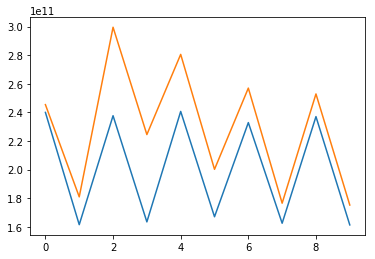

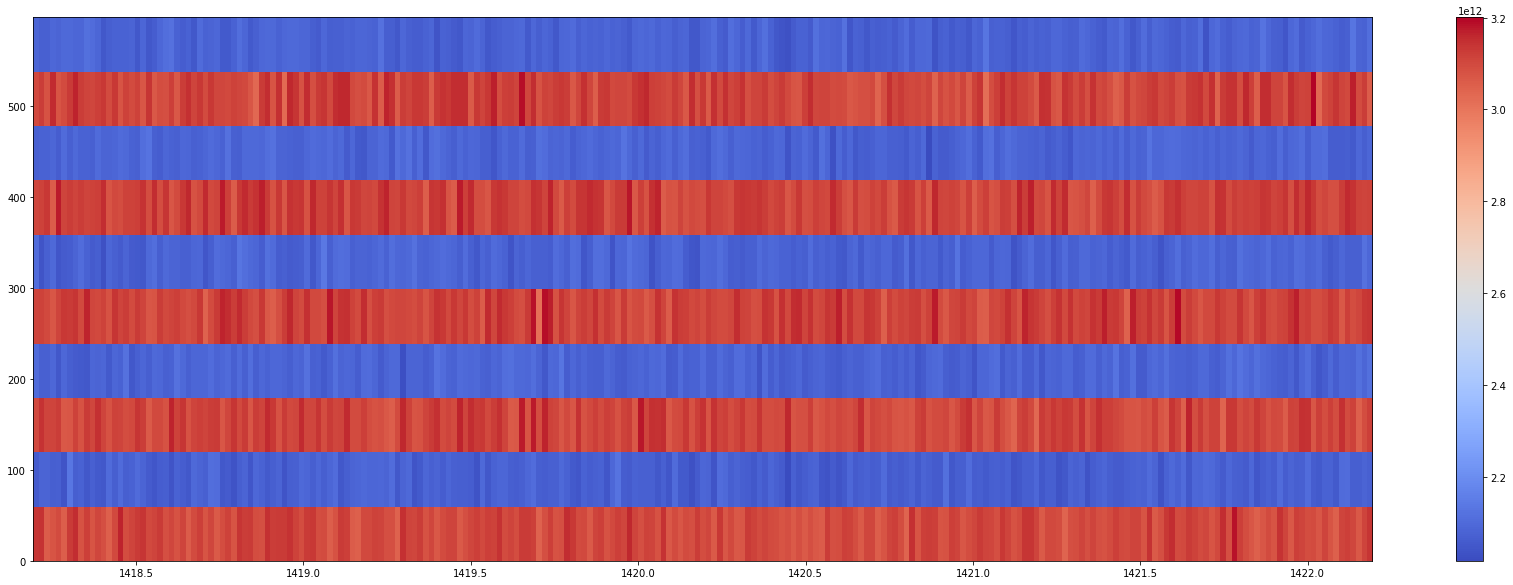

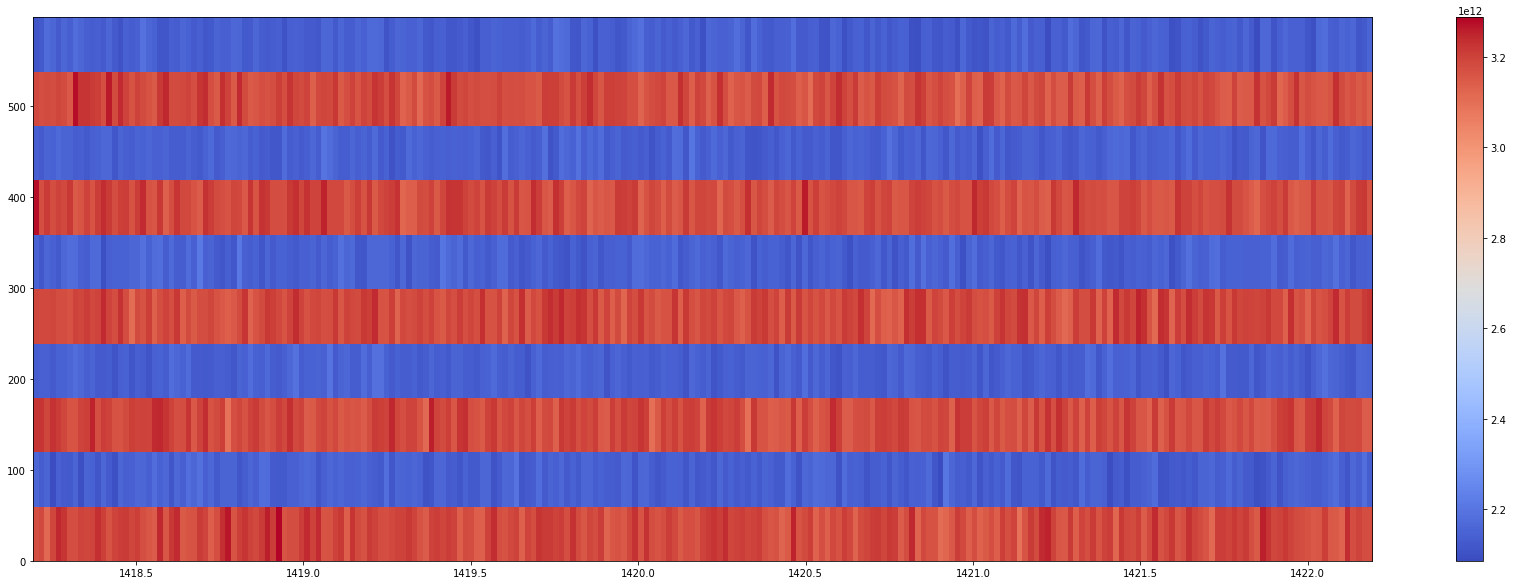

In [18]:
plt.plot(power1_on[0:10,40])
plt.plot(power1_off[0:10,40])

idx_power1_on_calon  = np.arange(0,595,2)
idx_power1_on_caloff = np.arange(1,596,2)

if power1_on[0,40] > power1_on[1,40]:
    power1_on_calon  = power1_on[np.arange(0,595,2),:]
    power1_on_caloff = power1_on[np.arange(1,596,2),:]
else:
    power1_on_calon  = power1_on[np.arange(1,596,2),:]
    power1_on_caloff = power1_on[np.arange(0,595,2),:]



if power1_off[0,40] > power1_off[1,40]:
    power1_off_calon  = power1_off[np.arange(0,595,2),:]
    power1_off_caloff = power1_off[np.arange(1,596,2),:]
else:
    power1_off_calon  = power1_off[np.arange(1,596,2),:]
    power1_off_caloff = power1_off[np.arange(0,595,2),:]


power1_on_calon.shape, power1_on_caloff.shape 
power1_on_calres = power1_on_calon-power1_on_caloff 
power1_off_calres = power1_off_calon-power1_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power1_on[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power1_off[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power1_on_calres,axis=0)


Ta1_on = power1_on_calon - power1_on_calon
for i, iTal_on in enumerate(Ta1_on):
    
    a   = power1_on_calon[i,:] * T_to_P_freq 
    c   = power1_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_on[i,:]  =  w1 * (power1_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_on_caloff[i,:] * T_to_P_freq)
    
    
Ta1_off = power1_off_calon - power1_off_calon
for i, iTal_off in enumerate(Ta1_off):
    
    a   = power1_off_calon[i,:] * T_to_P_freq 
    c   = power1_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta1_off[i,:]  =  w1 * (power1_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power1_off_caloff[i,:] * T_to_P_freq)


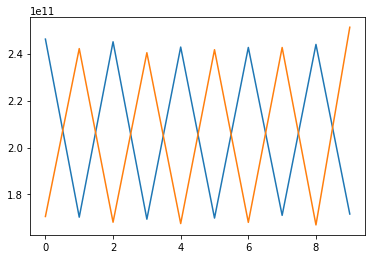

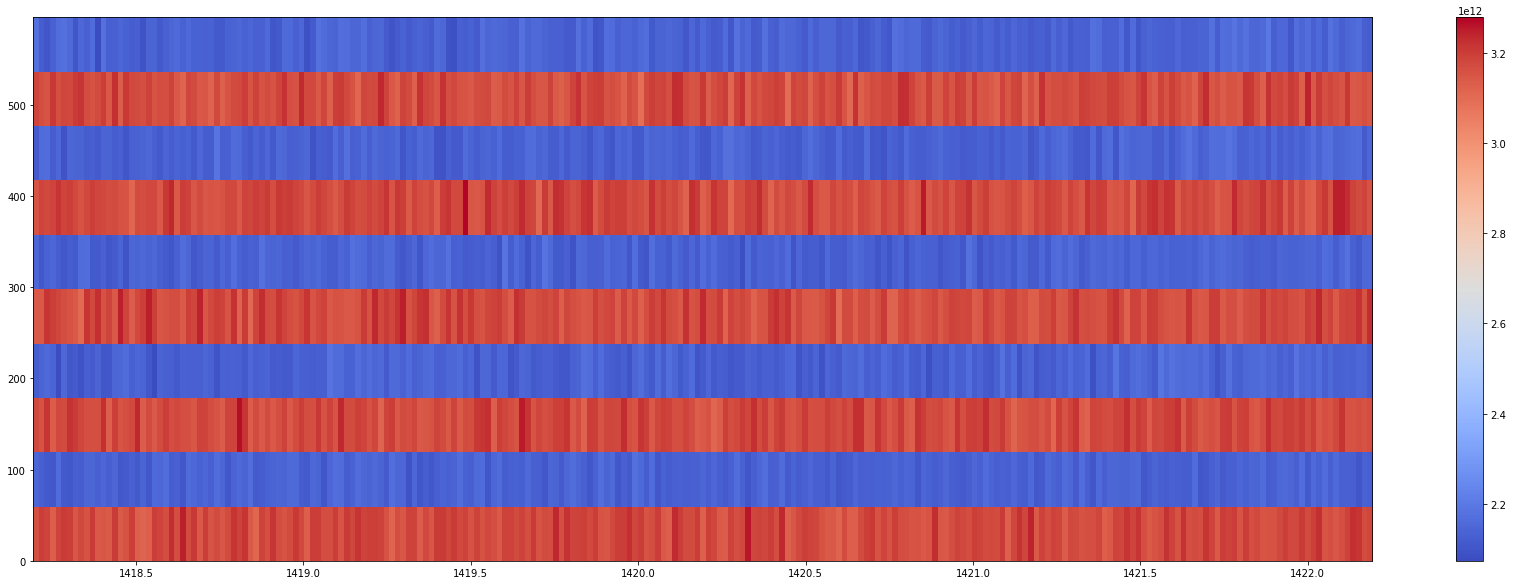

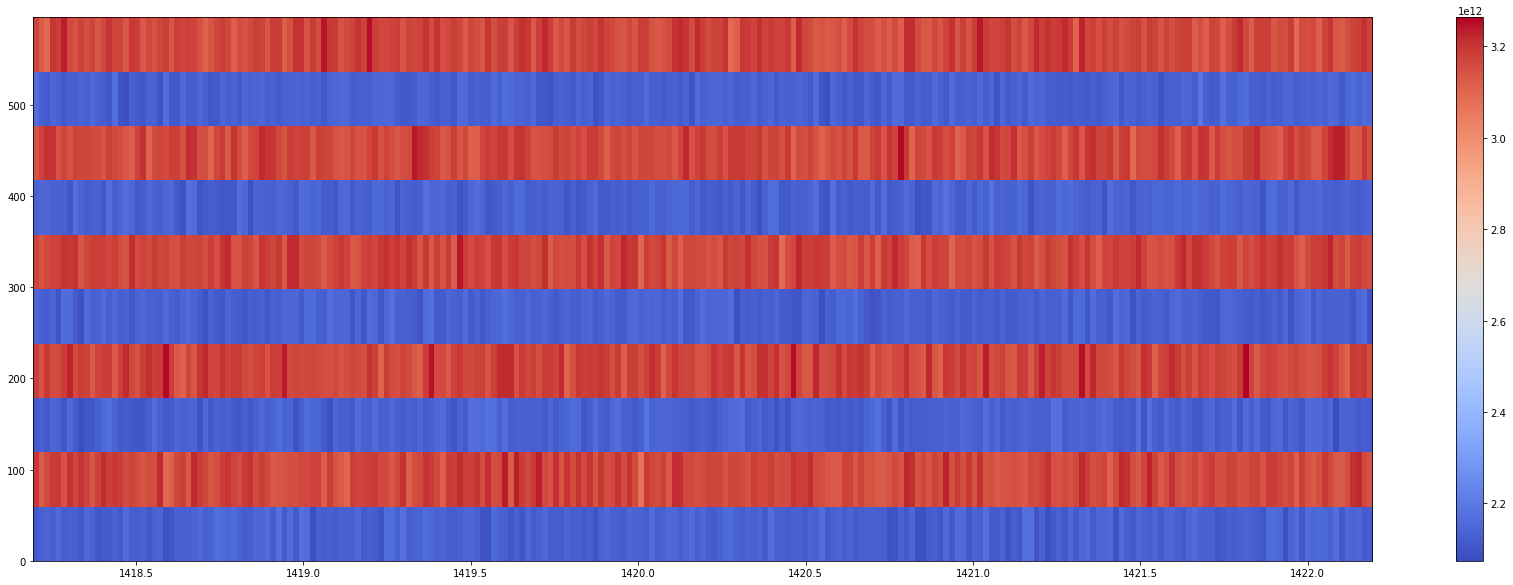

In [19]:
plt.plot(power2_on[0:10,40])
plt.plot(power2_off[0:10,40])

idx_power2_on_calon  = np.arange(0,595,2)
idx_power2_on_caloff = np.arange(1,596,2)

if power2_on[0,40] > power2_on[1,40]:
    power2_on_calon  = power2_on[np.arange(0,595,2),:]
    power2_on_caloff = power2_on[np.arange(1,596,2),:]
else:
    power2_on_calon  = power2_on[np.arange(1,596,2),:]
    power2_on_caloff = power2_on[np.arange(0,595,2),:]



if power2_off[0,40] > power2_off[1,40]:
    power2_off_calon  = power2_off[np.arange(0,595,2),:]
    power2_off_caloff = power2_off[np.arange(1,596,2),:]
else:
    power2_off_calon  = power2_off[np.arange(1,596,2),:]
    power2_off_caloff = power2_off[np.arange(0,595,2),:]


power2_on_calon.shape, power2_on_caloff.shape 
power2_on_calres = power2_on_calon-power2_on_caloff 
power2_off_calres = power2_off_calon-power2_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power2_on[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power2_off[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power2_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power2_on_calres,axis=0)


Ta2_on = power2_on_calon - power2_on_calon
for i, iTal_on in enumerate(Ta2_on):
    
    a   = power2_on_calon[i,:] * T_to_P_freq 
    c   = power2_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_on[i,:]  =  w1 * (power2_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_on_caloff[i,:] * T_to_P_freq)
    
    
Ta2_off = power2_off_calon - power2_off_calon
for i, iTal_off in enumerate(Ta2_off):
    
    a   = power2_off_calon[i,:] * T_to_P_freq 
    c   = power2_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta2_off[i,:]  =  w1 * (power2_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power2_off_caloff[i,:] * T_to_P_freq)


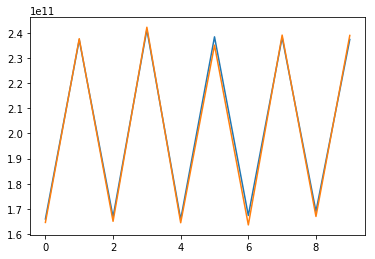

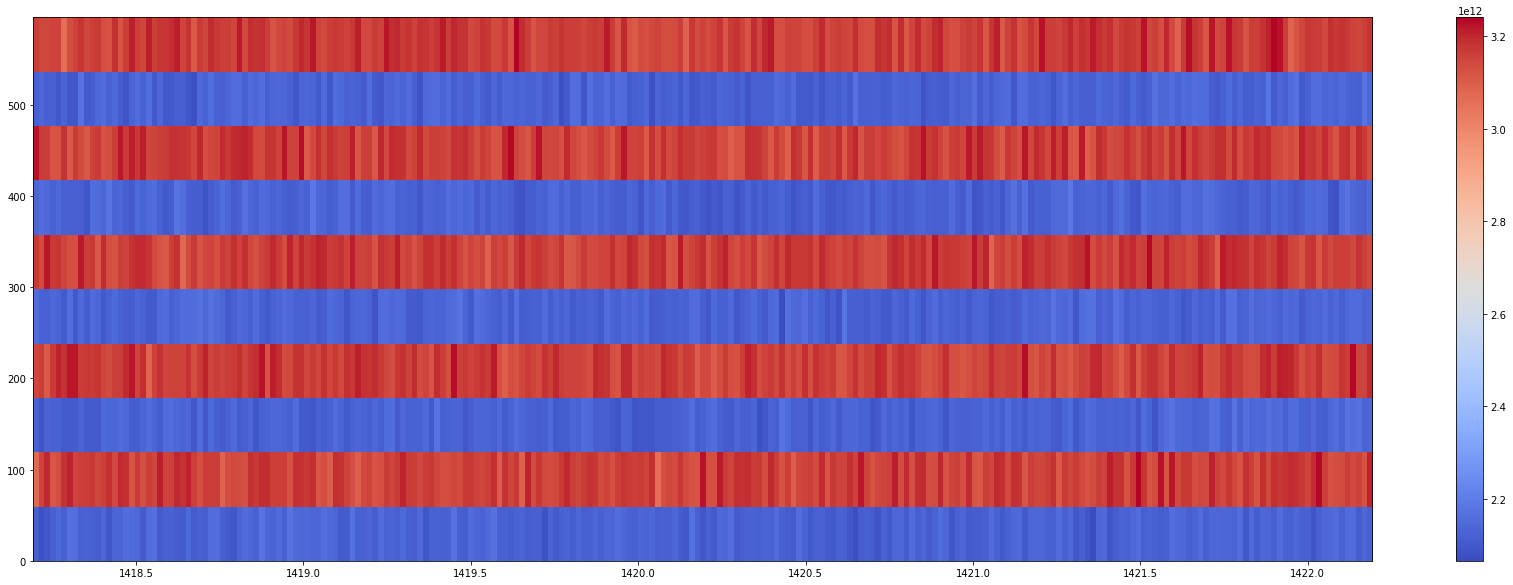

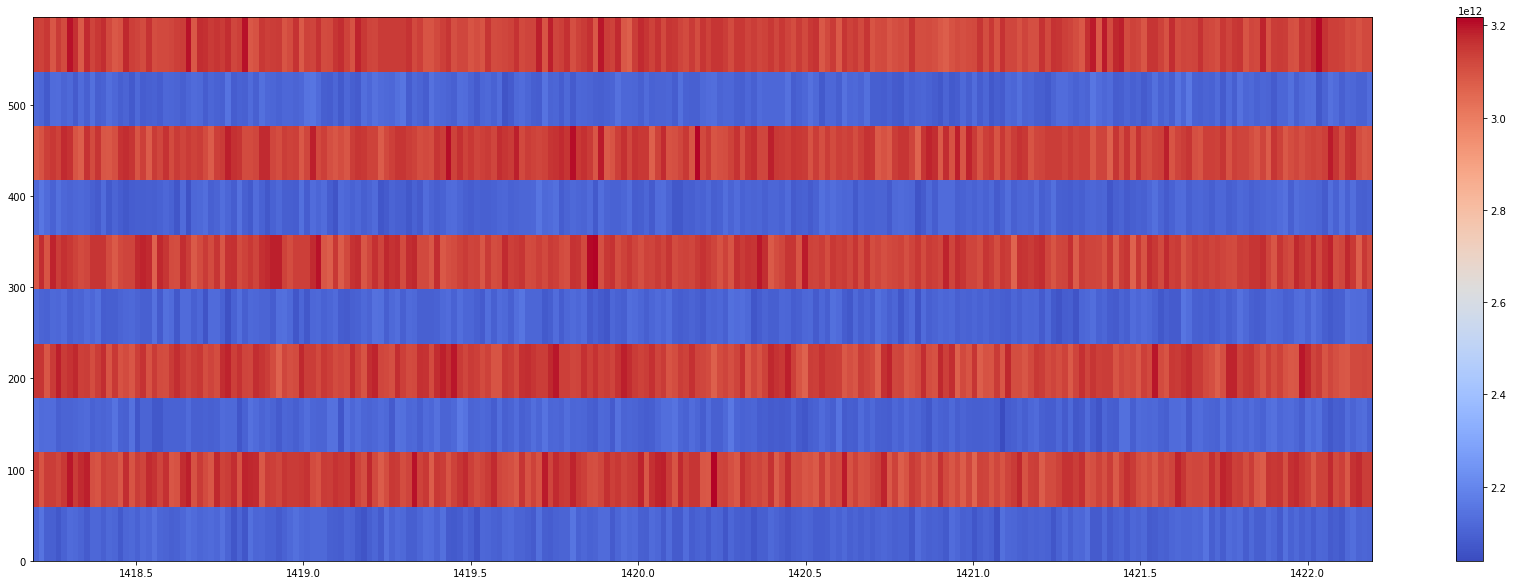

In [20]:
plt.plot(power3_on[0:10,40])
plt.plot(power3_off[0:10,40])

idx_power3_on_calon  = np.arange(0,595,2)
idx_power3_on_caloff = np.arange(1,596,2)

if power3_on[0,40] > power3_on[1,40]:
    power3_on_calon  = power3_on[np.arange(0,595,2),:]
    power3_on_caloff = power3_on[np.arange(1,596,2),:]
else:
    power3_on_calon  = power3_on[np.arange(1,596,2),:]
    power3_on_caloff = power3_on[np.arange(0,595,2),:]



if power3_off[0,40] > power3_off[1,40]:
    power3_off_calon  = power3_off[np.arange(0,595,2),:]
    power3_off_caloff = power3_off[np.arange(1,596,2),:]
else:
    power3_off_calon  = power3_off[np.arange(1,596,2),:]
    power3_off_caloff = power3_off[np.arange(0,595,2),:]


power3_on_calon.shape, power3_on_caloff.shape 
power3_on_calres = power3_on_calon-power3_on_caloff 
power3_off_calres = power3_off_calon-power3_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power3_on[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power3_off[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power3_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power3_on_calres,axis=0)


Ta3_on = power3_on_calon - power3_on_calon
for i, iTal_on in enumerate(Ta3_on):
    
    a   = power3_on_calon[i,:] * T_to_P_freq 
    c   = power3_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_on[i,:]  =  w1 * (power3_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_on_caloff[i,:] * T_to_P_freq)
    
    
Ta3_off = power3_off_calon - power3_off_calon
for i, iTal_off in enumerate(Ta3_off):
    
    a   = power3_off_calon[i,:] * T_to_P_freq 
    c   = power3_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta3_off[i,:]  =  w1 * (power3_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power3_off_caloff[i,:] * T_to_P_freq)


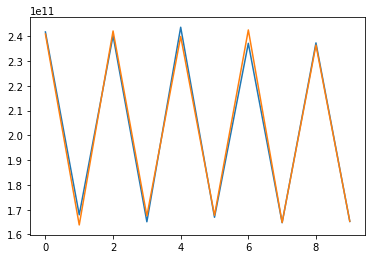

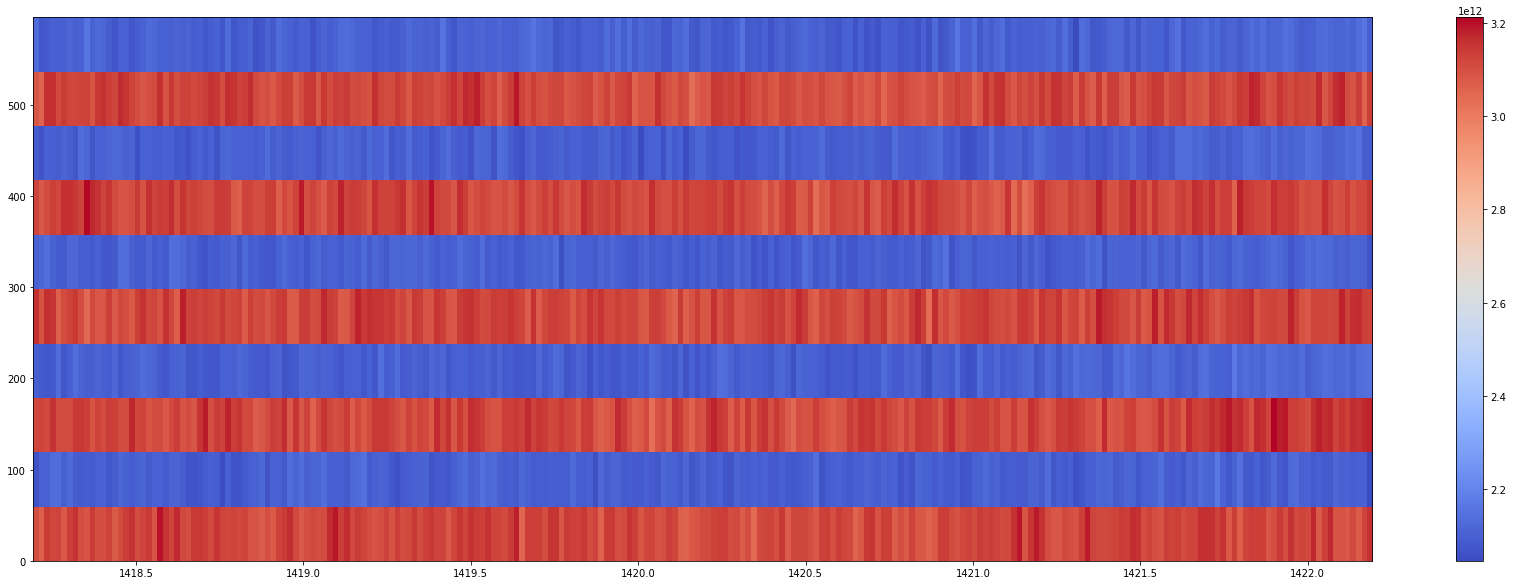

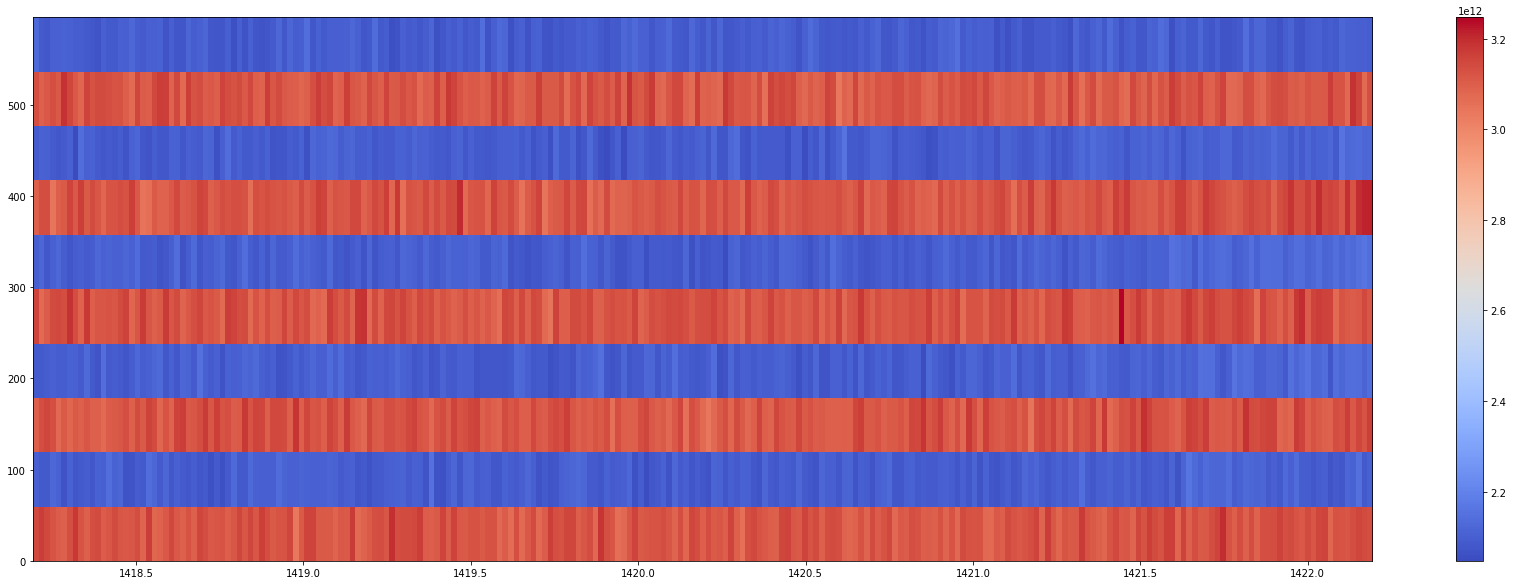

In [21]:
plt.plot(power4_on[0:10,40])
plt.plot(power4_off[0:10,40])

idx_power4_on_calon  = np.arange(0,595,2)
idx_power4_on_caloff = np.arange(1,596,2)

if power4_on[0,40] > power4_on[1,40]:
    power4_on_calon  = power4_on[np.arange(0,595,2),:]
    power4_on_caloff = power4_on[np.arange(1,596,2),:]
else:
    power4_on_calon  = power4_on[np.arange(1,596,2),:]
    power4_on_caloff = power4_on[np.arange(0,595,2),:]



if power4_off[0,40] > power4_off[1,40]:
    power4_off_calon  = power4_off[np.arange(0,595,2),:]
    power4_off_caloff = power4_off[np.arange(1,596,2),:]
else:
    power4_off_calon  = power4_off[np.arange(1,596,2),:]
    power4_off_caloff = power4_off[np.arange(0,595,2),:]


power4_on_calon.shape, power4_on_caloff.shape 
power4_on_calres = power4_on_calon-power4_on_caloff 
power4_off_calres = power4_off_calon-power4_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power4_on[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power4_off[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power4_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power4_on_calres,axis=0)


Ta4_on = power4_on_calon - power4_on_calon
for i, iTal_on in enumerate(Ta4_on):
    
    a   = power4_on_calon[i,:] * T_to_P_freq 
    c   = power4_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_on[i,:]  =  w1 * (power4_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_on_caloff[i,:] * T_to_P_freq)
    
    
Ta4_off = power4_off_calon - power4_off_calon
for i, iTal_off in enumerate(Ta4_off):
    
    a   = power4_off_calon[i,:] * T_to_P_freq 
    c   = power4_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta4_off[i,:]  =  w1 * (power4_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power4_off_caloff[i,:] * T_to_P_freq)


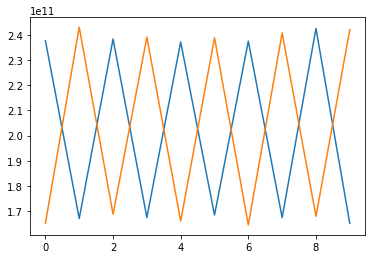

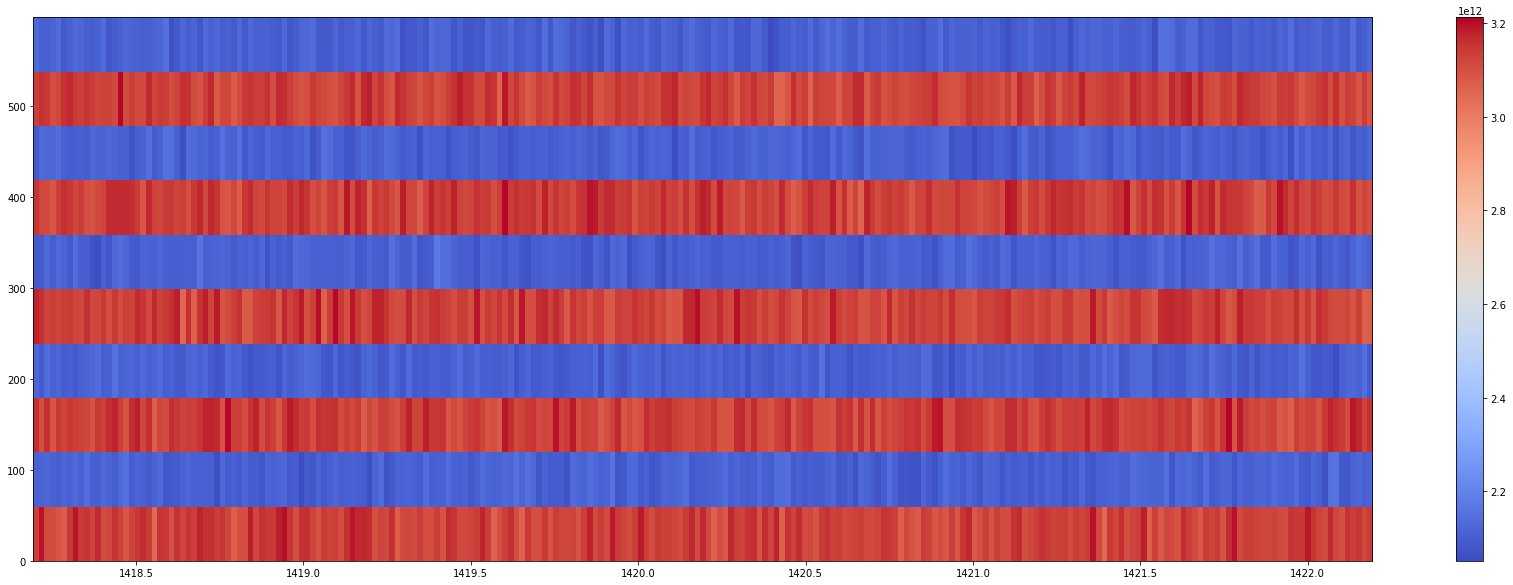

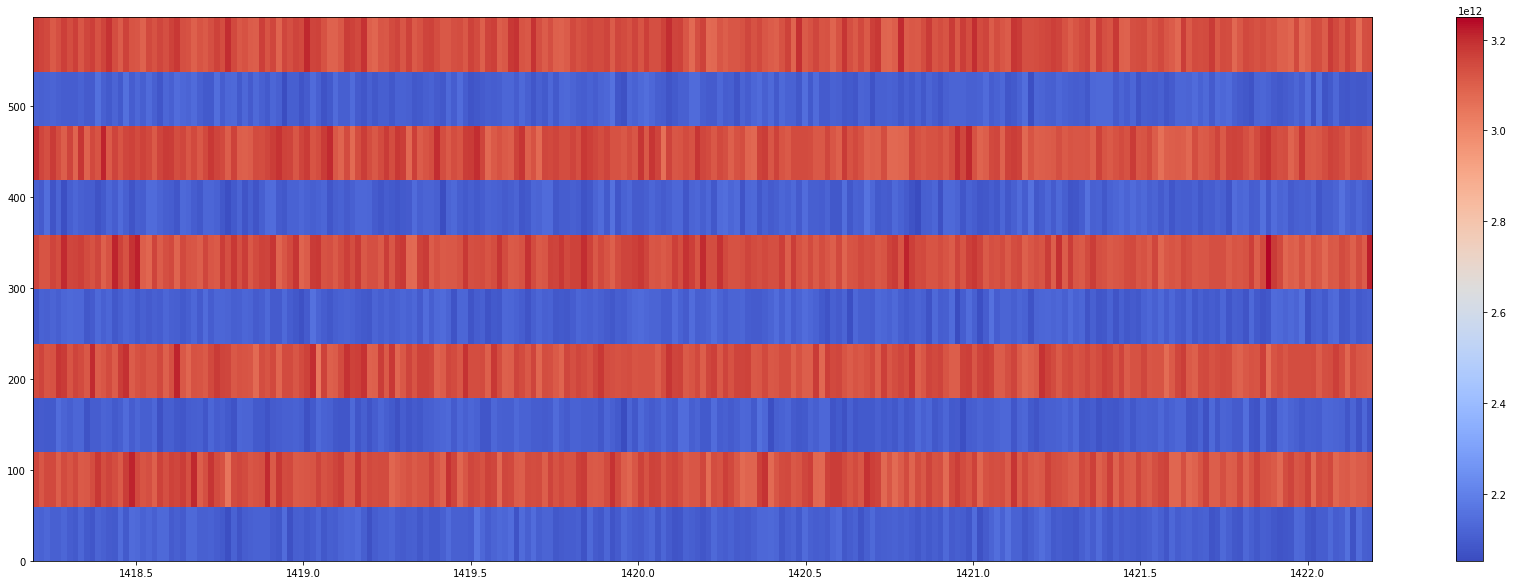

In [22]:
plt.plot(power5_on[0:10,40])
plt.plot(power5_off[0:10,40])

idx_power5_on_calon  = np.arange(0,595,2)
idx_power5_on_caloff = np.arange(1,596,2)

if power5_on[0,40] > power5_on[1,40]:
    power5_on_calon  = power5_on[np.arange(0,595,2),:]
    power5_on_caloff = power5_on[np.arange(1,596,2),:]
else:
    power5_on_calon  = power5_on[np.arange(1,596,2),:]
    power5_on_caloff = power5_on[np.arange(0,595,2),:]



if power5_off[0,40] > power5_off[1,40]:
    power5_off_calon  = power5_off[np.arange(0,595,2),:]
    power5_off_caloff = power5_off[np.arange(1,596,2),:]
else:
    power5_off_calon  = power5_off[np.arange(1,596,2),:]
    power5_off_caloff = power5_off[np.arange(0,595,2),:]


power5_on_calon.shape, power5_on_caloff.shape 
power5_on_calres = power5_on_calon-power5_on_caloff 
power5_off_calres = power5_off_calon-power5_off_caloff 


#here we need to check if the noise on-off-on-off works well when we split the data
plt.figure(figsize=(30,10))
plt.imshow(power5_on[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()

plt.figure(figsize=(30,10))
plt.imshow(power5_off[0:10,((freq > freq_min) & (freq < 1420))], aspect='auto', origin = 'lower', 
           extent=(freq_min, freq_max,0,power1_on[:,0].size), 
          cmap='coolwarm')
plt.colorbar()


# For each frequency:
T_to_P_freq = Tcal / np.average(power5_on_calres,axis=0)


Ta5_on = power5_on_calon - power5_on_calon
for i, iTal_on in enumerate(Ta5_on):
    
    a   = power5_on_calon[i,:] * T_to_P_freq 
    c   = power5_on_caloff[i,:] * T_to_P_freq
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_on[i,:]  =  w1 * (power5_on_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_on_caloff[i,:] * T_to_P_freq)
    
    
Ta5_off = power5_off_calon - power5_off_calon
for i, iTal_off in enumerate(Ta5_off):
    
    a   = power5_off_calon[i,:] * T_to_P_freq 
    c   = power5_off_caloff[i,:] * T_to_P_freq
    
    w1  = c**2/(a**2+c**2)
    w2  = a**2/(a**2+c**2)

    Ta5_off[i,:]  =  w1 * (power5_off_calon[i,:] * T_to_P_freq - Tcal) + w2 * (power5_off_caloff[i,:] * T_to_P_freq)


In [23]:
Ta_on = np.vstack((Ta1_on,Ta2_on,Ta3_on,Ta4_on,Ta5_on))
Ta_off = np.vstack((Ta1_off,Ta2_off,Ta3_off,Ta4_off,Ta5_off))


In [26]:
Ta_on.shape, Ta_off.shape

((1490, 65536), (1490, 65536))

In [27]:
np.average(Ta_on, axis=0).shape

(65536,)

(1419, 1420.35)

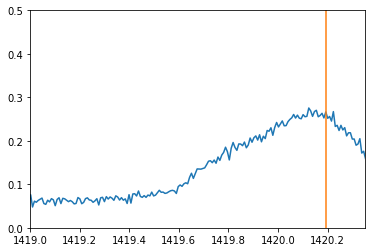

In [37]:
plt.plot(freq, np.average(Ta_on, axis=0) - np.average(Ta_off, axis=0))
plt.plot([freq_line, freq_line], [0,1])
plt.ylim(0,0.5)
plt.xlim(1419,1420.35)

In [38]:
Tasave = fits.HDUList()
Tasave.append(fits.ImageHDU(data=Ta_on))
Tasave.writeto('Ta_on_M01.fits')

In [41]:
Tasave = fits.HDUList()
Tasave.append(fits.ImageHDU(data=Ta_off))
Tasave.writeto('Ta_off_M01.fits')